# Prepare EEG data for training of machine-learning models

In this notebook, the preprocessing for machine learning purposes is done. Also, some exploration and visualization is done to better understand the data at hand.

+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.
+ Select features

## Import packages & links

In [1]:
# Import packages
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

sns.set_theme(style="whitegrid")
%matplotlib inline
# %matplotlib qt

C:\Users\makeda\anaconda3\envs\mne-march2\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\mne-march2\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\mne-march2\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [32]:
import fnmatch
import warnings
import re
warnings.filterwarnings('ignore')

import helper_functions

In [33]:
from config_for_repro_prepro  import PATH_RAW_DATA, PATH_METADATA, PATH_DATA_PROCESSED_ML

In [34]:
# add overwrite step 
PATH_RAW_DATA= 'C:/Projects/EEG_explorer/Data'

## Search all *.cnt files and get paths, code, and age group

In [35]:


# dir_names = {5: '5mnd mmn',
#              11: '11mnd mmn',
#              17: '17mnd mmn',
#              23: '23mnd mmn',
#              29: '29mnd mmn',
#              35: '35mnd mmn',
#              41: '41mnd mmn',
#              47: '47mnd mmn'}

# dir_names = {11: '11mnd mmn',
#              17: '17mnd mmn',
#              23: '23mnd mmn',
#              29: '29mnd mmn',
#              35: '35mnd mmn',
#              41: '41mnd mmn',
#              47: '47mnd mmn',
# }
    
# df_list = []

# for age_group, directory in dir_names.items(): # Go into every age group folder        
#     dir_path = os.path.join('C:/Projects/EEG_explorer/Data', directory)
#     file_names = os.listdir(dir_path)
#     cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
#     cnt_files = [x.split('/')[-1][:-4] for x in cnt_paths]
#     codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
#     df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns =['code', 'cnt_path','cnt_file']) 
    
#     df['age_group'] = age_group
#     df_list.append(df)

# cnt_files = pd.concat(df_list)

In [36]:
dir_names = {11: '11mnd mmn',
             17: '17mnd mmn',
             23: '23mnd mmn',
             29: '29mnd mmn',
             35: '35mnd mmn',
             41: '41mnd mmn',
             47: '47mnd mmn'}
    
df_list = []

for age_group, directory in dir_names.items(): # Go into every age group folder        
    dir_path = os.path.join('C:/Projects/EEG_explorer/Data', directory)
    file_names = os.listdir(dir_path)
    
    cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
    # list comprehension - creates a list of all cnt file names with thisdirectory
    cnt_files = [os.path.basename(x)[:-4] for x in cnt_paths]
    # list comprehension
    codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
    # takes number out of string (\d+ takes out digits)
    df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns=['code', 'cnt_path','cnt_file']) 
    
    df['age_group'] = age_group
    df_list.append(df)

cnt_files = pd.concat(df_list)

In [37]:
cnt_files.head()

,code,cnt_path,cnt_file,age_group
0,1,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk,11
1,3,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp,11
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11
3,5,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2,11
4,7,C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...,007_11_jc_mmn2_36_wk,11


## Search for all age files and create DataFrame containing all ages per subject code

In [38]:
# age_files = {5: 'ages_5mnths.txt',
#              11: 'ages_11mnths.txt',
#              17: 'ages_17mnths.txt',
#              23: 'ages_23mnths.txt',
#              29: 'ages_29mnths.txt',
#              35: 'ages_35mnths.txt',
#              41: 'ages_41mnths.txt',
#              47: 'ages_47mnths.txt'}

age_files = {11: 'ages_11mnths.txt',
             17: 'ages_17mnths.txt',
             23: 'ages_23mnths.txt',
             29: 'ages_29mnths.txt',
             35: 'ages_35mnths.txt',
             41: 'ages_41mnths.txt',
             47: 'ages_47mnths.txt'}

df_list = []

for age_group, age_file in age_files.items():
    df = pd.read_csv(os.path.join(PATH_METADATA, 'ages', age_file), sep="\t")
    df['age_group'] = age_group
    df_list.append(df)

age_df = pd.concat(df_list)

In [39]:
age_df

,code,age_days,age_months,age_years,age_group
0,1,329,10.966667,0.913889,11
1,3,336,11.200000,0.933333,11
2,5,329,10.966667,0.913889,11
3,6,319,10.633333,0.886111,11
4,7,329,10.966667,0.913889,11
...,...,...,...,...,...
74,731,1409,46.966667,3.913889,47
75,732,1412,47.066667,3.922222,47
76,733,1404,46.800000,3.900000,47
77,734,1405,46.833333,3.902778,47


### Merge the .cnt files with the age information we have on the subjects

In [45]:
#merged_df = pd.merge(age_df, cnt_files, how='left', on=['age_group','code'])

In [46]:
merged_df = pd.merge(cnt_files, age_df, how='left', on=['age_group', 'code'])

In [47]:
merged_df.head()

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,1,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk,11,329.0,10.966667,0.913889
1,3,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp,11,336.0,11.200000,0.933333
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11,NaN,NaN,NaN
3,5,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2,11,329.0,10.966667,0.913889
4,7,C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...,007_11_jc_mmn2_36_wk,11,329.0,10.966667,0.913889


## Visualize the age ranges within groups

In [48]:
data_11 = merged_df.loc[merged_df['age_group'] == 11]
data_17 = merged_df.loc[merged_df['age_group'] == 17]
data_23 = merged_df.loc[merged_df['age_group'] == 23]
data_29 = merged_df.loc[merged_df['age_group'] == 29]
data_35 = merged_df.loc[merged_df['age_group'] == 35]
data_41 = merged_df.loc[merged_df['age_group'] == 41]
data_47 = merged_df.loc[merged_df['age_group'] == 47]
data = [data_11, data_17, data_23, data_29, data_35, data_41, data_47]

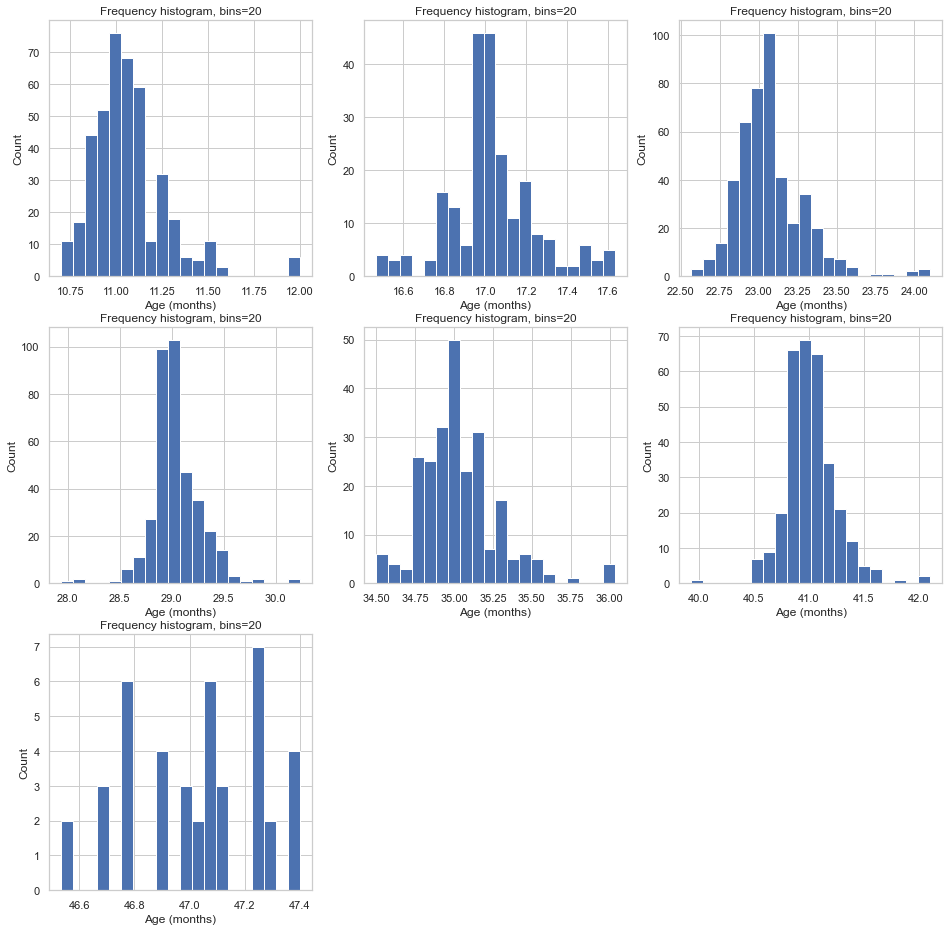

In [49]:
%matplotlib inline

bins = 20

fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        ax.hist(data[i]['age_months'], bins=bins)
        ax.set_xlabel('Age (months)')
        ax.set_ylabel('Count')
        ax.set_title(f'Frequency histogram, bins={bins}')

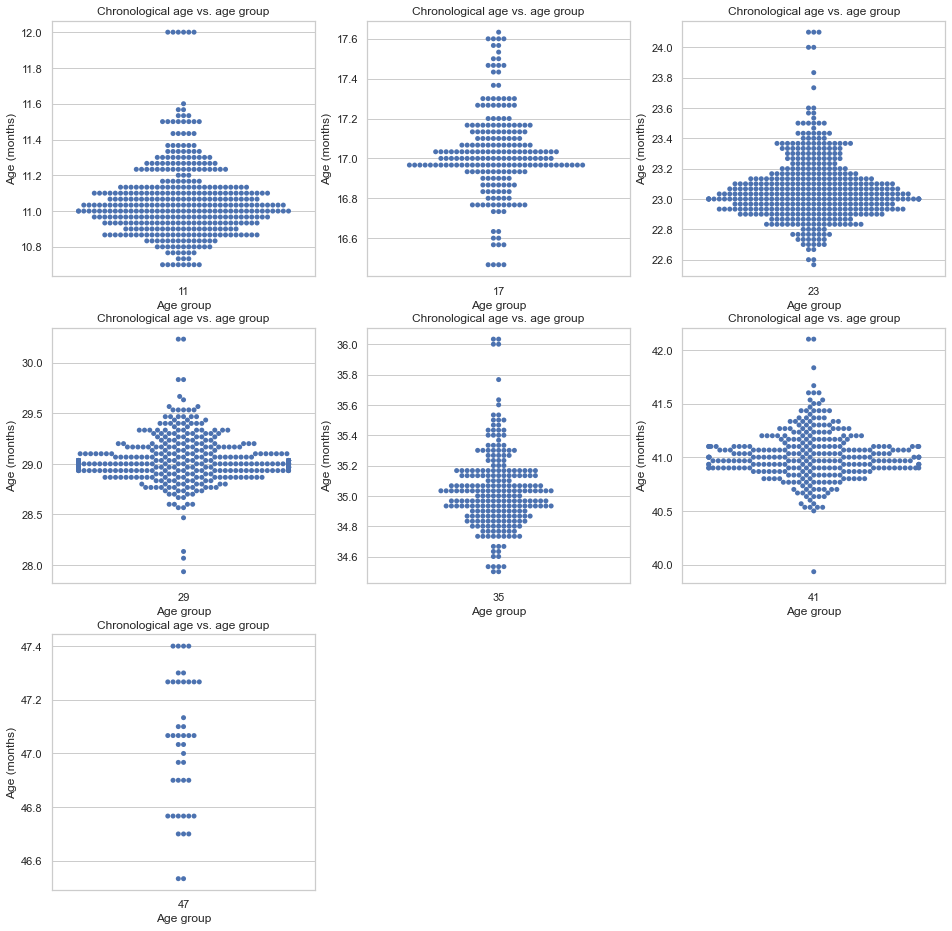

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        sns.swarmplot(ax=ax, x="age_group", y="age_months", data=data[i])
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

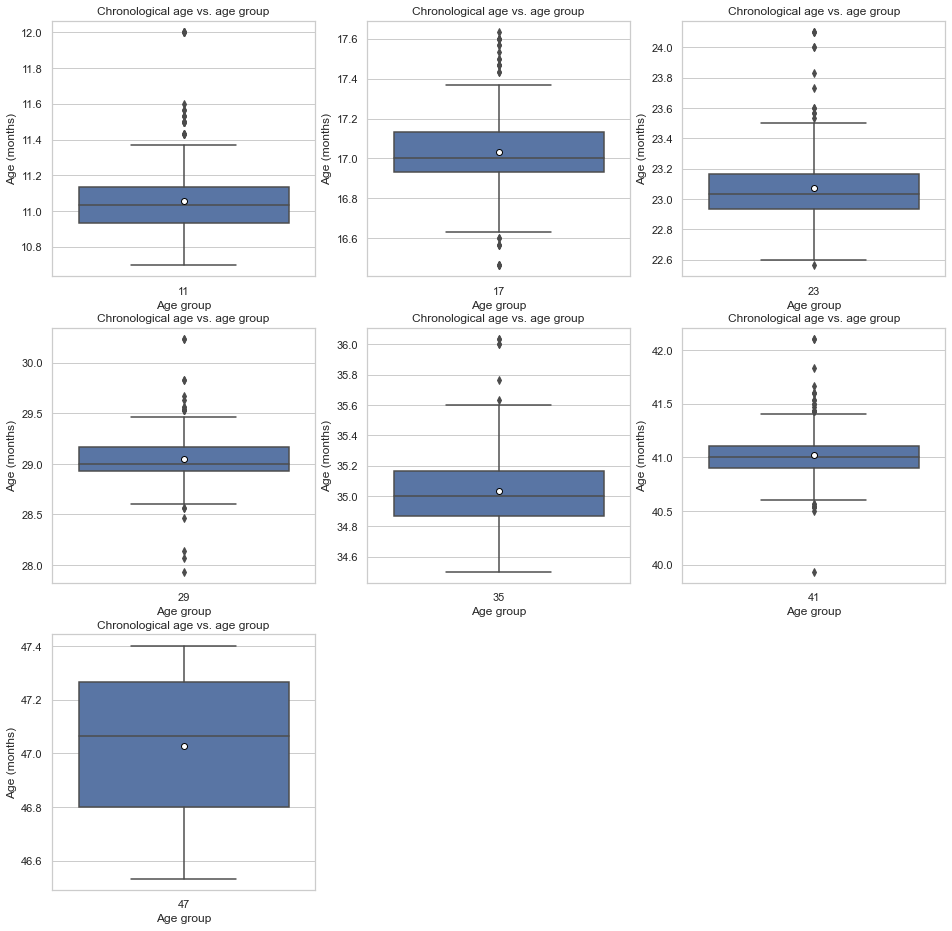

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:    
        sns.boxplot(ax=ax, x="age_group", y="age_months", data=data[i], showmeans=True, 
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                           "markersize":"6"})
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

## Check files with no label 

In [52]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11,NaN,NaN,NaN
9,9,C:/Projects/EEG_explorer/Data\11mnd mmn\009_11...,009_11_jc_mmn36_wk_mmn25_wk,11,NaN,NaN,NaN
10,9,C:/Projects/EEG_explorer/Data\11mnd mmn\009_11...,009_11_jc_mmn47_wk,11,NaN,NaN,NaN
35,31,C:/Projects/EEG_explorer/Data\11mnd mmn\031_11...,031_11_mc_mmn36_wk,11,NaN,NaN,NaN
49,101,C:/Projects/EEG_explorer/Data\11mnd mmn\101_11...,101_11_jr_mmn,11,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1978,433,C:/Projects/EEG_explorer/Data\41mnd mmn\433_41...,433_41_jd_mmn25_slp,41,NaN,NaN,NaN
1979,433,C:/Projects/EEG_explorer/Data\41mnd mmn\433_41...,433_41_jd_mmn36_mix,41,NaN,NaN,NaN
2031,616,C:/Projects/EEG_explorer/Data\41mnd mmn\616-24...,616-240-41m-mc-mmn39,41,NaN,NaN,NaN
2123,119,C:/Projects/EEG_explorer/Data\47mnd mmn\119_47...,119_47_jr_mmn39,47,NaN,NaN,NaN


### Fill in the missing age data based on the age group the subject is in

We know the age group (i.e. 11, 17, 23, .. months etc) of all the subjects, based on the folder the files are in and based on the file name. We have got the exact ages (in days) of most subjects seperately, which we have added to the DataFrame above. For some of the subjects, we don't have the exact age and therefore we set this equal to the age group.

In [53]:
merged_df['age_months'].fillna(merged_df['age_group'], inplace=True)
merged_df['age_days'].fillna(merged_df['age_group']*30, inplace=True)
merged_df['age_years'].fillna(merged_df['age_group']/12, inplace=True)

Below should now return an empty dataframe, because all empty fields have been filled

In [54]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years


In [55]:
merged_df

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,1,C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...,001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk,11,329.0,10.966667,0.913889
1,3,C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...,003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp,11,336.0,11.200000,0.933333
2,4,C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...,004_11_mc_mmn,11,330.0,11.000000,0.916667
3,5,C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...,005_11_jc_mmn2,11,329.0,10.966667,0.913889
4,7,C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...,007_11_jc_mmn2_36_wk,11,329.0,10.966667,0.913889
...,...,...,...,...,...,...,...
2144,704,C:/Projects/EEG_explorer/Data\47mnd mmn\704-03...,704-032-47m-jr-mmn36,47,1422.0,47.400000,3.950000
2145,705,C:/Projects/EEG_explorer/Data\47mnd mmn\705-05...,705-050-47m-jr-mmn36,47,1407.0,46.900000,3.908333
2146,709,C:/Projects/EEG_explorer/Data\47mnd mmn\709-07...,709-078-47m-jr-mmn36,47,1419.0,47.300000,3.941667
2147,710,C:/Projects/EEG_explorer/Data\47mnd mmn\710-07...,710-078-47m-jr-mmn36,47,1412.0,47.066667,3.922222


## Explore EEG data

### Import EEG data (from .cnt files)

In [56]:
# Select a file
file = merged_df['cnt_path'][500] # just a random file number

# Import file 
data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)

Reading 0 ... 1497319  =      0.000 ...  2994.638 secs...


## What does the data look like?

In [57]:
print('Data type: {}\n\n{}\n'.format(type(data_raw), data_raw))

# Get the sample rate
print('Sample rate:', data_raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(data_raw.get_data().shape))

# The mne.info class can be used to learn more about the data.
print(data_raw.info)

Data type: <class 'mne.io.cnt.cnt.RawCNT'>

<RawCNT | 119_17_jr_mmn.cnt, 64 x 1497320 (2994.6 s), ~731.2 MB, data loaded>

Sample rate: 500.0 Hz
Size of the matrix: (64, 1497320)

<Info | 8 non-empty values
 bads: []
 ch_names: O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, T8, P7, P3, CP3, CPZ, CZ, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>


### Show data as pandas dataframe (i.e. as a table).
The raw data itself is just an array dimensions are no. of channels and timepoint.

In [58]:
raw_df = data_raw.to_data_frame()
raw_df.head()

,time,O2,O1,OZ,PZ,P4,CP4,P8,C4,TP8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,0,175.054330,29.468177,150.890922,286.713284,415.074493,291.448520,178.184993,175.347231,91.880159,...,229.772628,137.177278,11.968776,68.487220,128.269314,115.574839,7.313887,-27.772926,-47.252270,177.356866
1,2,185.658416,30.514385,158.192096,272.027969,414.373353,292.321120,177.661433,186.631953,87.190623,...,239.210638,148.881236,19.774500,78.370186,140.353906,128.069416,-5.398345,-13.624454,-42.059713,190.615583
2,4,194.350289,32.781167,163.233382,266.433563,414.548638,293.542760,178.708553,197.569454,84.932699,...,247.790646,158.691907,26.192539,87.386225,149.503668,135.357919,-3.308663,-1.572052,-27.866723,202.324580
3,6,199.043901,36.791629,166.188619,269.580417,417.002626,295.462481,180.977314,204.687510,85.627445,...,251.909050,162.134248,30.529052,91.200703,151.920587,134.837312,10.274270,3.842795,-14.539160,206.629358
4,8,200.086926,40.802091,168.100832,276.398598,420.858892,298.254802,182.198955,207.986121,88.059056,...,251.051049,158.691907,35.559408,89.640235,148.640483,129.457702,26.643445,3.668122,-11.250541,204.390874


In [59]:
data_raw.info['bads']

[]

In [60]:
# Band-pass filter (between 1 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
data_raw.filter(1, 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



<RawCNT | 119_17_jr_mmn.cnt, 64 x 1497320 (2994.6 s), ~731.2 MB, data loaded>

### Plot channels

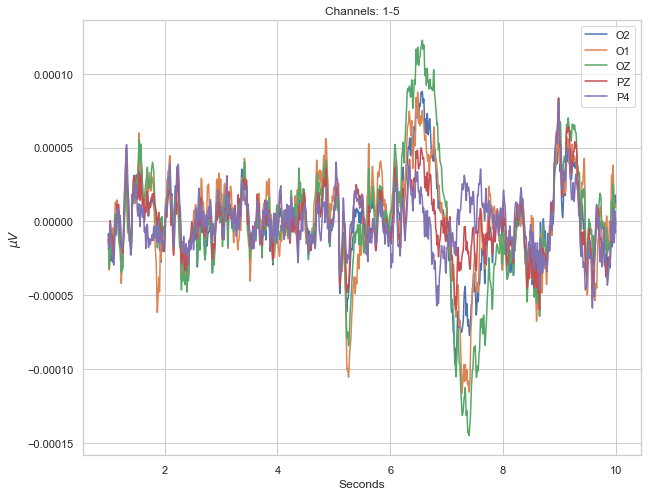

In [61]:
# Extract data from the first 5 channels, from 1 s to 10 s.
sfreq = data_raw.info['sfreq']
data, times = data_raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T)
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(data_raw.ch_names[:5])

### mne plots
There are many nice plotting options included in mne. They are, however, not always interactive and fully functional in Jupyter notebooks... so better try them out from a python script.

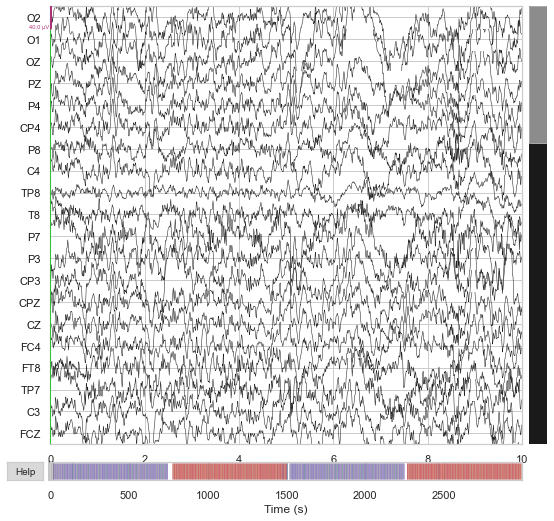

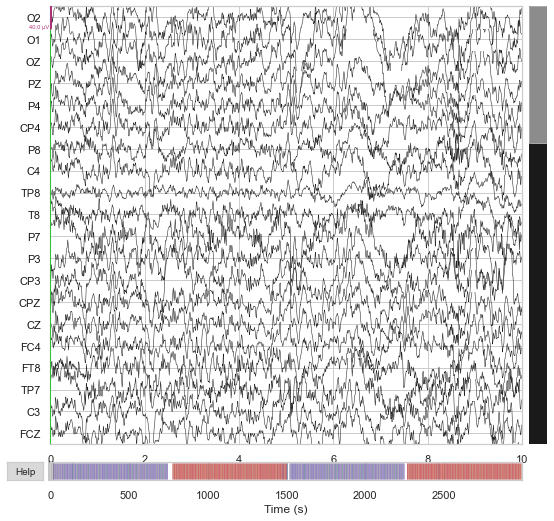

In [62]:
data_raw.plot(duration=10, block=True)

### Look at events 

In [63]:
# get the events
events, event_id = mne.events_from_annotations(data_raw)
print(events[:10,:])
print(event_id)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
[[ 7684     0     5]
 [ 8410     0     5]
 [ 9136     0     5]
 [ 9858     0     5]
 [10584     0     5]
 [11310     0     5]
 [12036     0     3]
 [12762     0     7]
 [13488     0     5]
 [14214     0     5]]
{'0': 1, '12': 2, '13': 3, '2': 4, '3': 5, '55': 6, '66': 7}


In [64]:
# Check which unique event indentifiers there are
unique_event_types = set(events[:,2])
print(unique_event_types)

{1, 2, 3, 4, 5, 6, 7}


### Search for most common event

In [65]:
tmin = -0.2
tmax = 0.8

baseline = (None, 0)  # means from the first instant to t = 0
counts = pd.Series()

for i, path in enumerate(merged_df['cnt_path']):        
    # Import file 
    try:
        raw = mne.io.read_raw_cnt(path, eog='auto', preload=True, verbose=False)
    except: 
        continue
    
    # Load events
    events_count, event_id_count = mne.events_from_annotations(raw, verbose=False)    
    event_id_count = {y:x for x,y in event_id_count.items()}
    
    temp_df = pd.DataFrame(events_count) 
    temp_df[2].replace(event_id_count, inplace=True)
    counts = counts.add(temp_df[2].value_counts(),fill_value=0)

print(counts)

# 0        3567.0
# 1       13263.0
# 10         18.0
# 104         1.0
# 11         12.0
# 112         2.0
# 12      44920.0
# 127       304.0
# 13     120790.0
# 14       8649.0
# 15       6600.0
# 16         13.0
# 17         13.0
# 18         93.0
# 19         75.0
# 2      357282.0
# 20         15.0
# 201         2.0
# 202         2.0
# 203         2.0
# 204         2.0
# 205         2.0
# 206         2.0
# 208         2.0
# 209         2.0
# 21         10.0
# 210         2.0
# 211         2.0
# 255         2.0
# 26          1.0
# 27          1.0
# 3      878840.0
# 31          1.0
# 33        614.0
# 35          1.0
# 36          2.0
# 4       72045.0
# 40         12.0
# 41          4.0
# 45          1.0
# 48         18.0
# 49         10.0
# 5       55476.0
# 55      44602.0
# 58          5.0
# 6          12.0
# 60          9.0
# 65          5.0
# 66      91848.0
# 7          12.0
# 72          4.0
# 73          7.0
# 77       8969.0
# 8          13.0
# 80         62.0
# 81         31.0
# 82          8.0
# 88       6894.0
# 9          12.0
# 99      28749.0
# dtype: float64

0        3523.0
1        5202.0
10         18.0
104         1.0
11         12.0
112         2.0
12      44653.0
127       304.0
13     120522.0
14       8608.0
15       6573.0
16         13.0
17         13.0
18         93.0
19         75.0
2      355167.0
20         15.0
201         2.0
202         2.0
203         2.0
204         2.0
205         2.0
206         2.0
208         2.0
209         2.0
21         10.0
210         2.0
211         2.0
255         2.0
26          1.0
27          1.0
3      876908.0
31          1.0
33        614.0
35          1.0
36          2.0
4       71706.0
40         12.0
41          4.0
45          1.0
48         18.0
49         10.0
5       55252.0
55      44337.0
58          5.0
6          12.0
60          9.0
65          5.0
66      91654.0
7          12.0
72          4.0
73          7.0
77       8928.0
8          13.0
80         62.0
81         31.0
82          8.0
88       6867.0
9          12.0
99      28676.0
dtype: float64


### Display signal around one type of event
Selects signal for specific event ID and plots time window from tmin to tmax.

In [66]:
# event_id = [1, 2, 3, 4] # select events for the given event IDs
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

print(picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [67]:
epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=True)

print(epochs)

Not setting metadata
Not setting metadata
2012 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2012 events and 351 original time points ...
0 bad epochs dropped
<Epochs |  2012 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~334.2 MB, data loaded,
 '0': 12
 '12': 100
 '13': 100
 '2': 800
 '3': 800
 '55': 100
 '66': 100>


In [68]:
# Export data in tabular structure as a pandas DataFrame.
epochs_df = epochs.to_data_frame()
epochs_df.head()

,time,condition,epoch,O2,O1,OZ,PZ,P4,CP4,P8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,-200,3,0,19.733487,22.597901,20.047278,11.217764,2.835124,7.186990,-4.227798,...,0.470223,-7.124972,2.163766,2.438343,2.643083,2.230914,6.519844,1.897849,2.119677,0.088040
1,-198,3,0,20.655105,23.620044,21.116976,12.893161,4.508536,8.701691,-3.361994,...,3.613162,-4.806182,2.521073,5.027857,5.431945,5.048605,7.564638,3.832950,4.351600,1.953257
2,-196,3,0,21.837246,24.527912,22.449666,14.617161,6.066433,9.963521,-2.762263,...,6.810397,-2.267107,3.239110,7.844382,8.297986,7.850240,9.621177,6.715257,6.696419,4.096949
3,-194,3,0,23.185903,25.159274,23.834357,16.295032,7.396069,10.996093,-2.481381,...,9.839636,0.406558,4.405409,10.674934,11.066978,10.475421,12.428237,10.308709,9.007766,6.491404
4,-192,3,0,24.521683,25.356660,24.990797,17.801691,8.419938,11.847577,-2.519168,...,12.475150,3.079324,6.023836,13.294821,13.559116,12.794901,15.606350,14.251309,11.168117,9.045967


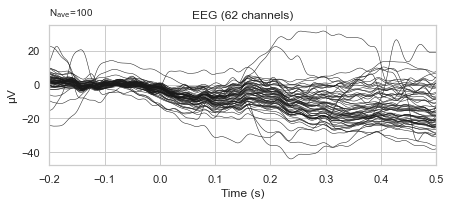

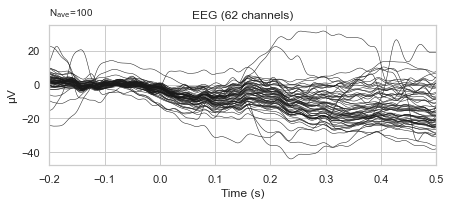

In [69]:
evoked = epochs['66'].average()
evoked.plot()

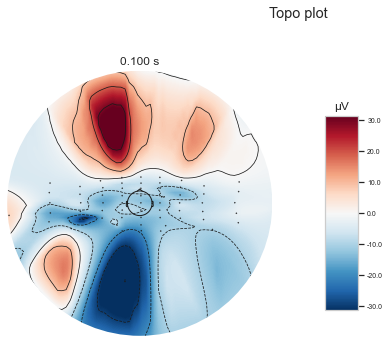

In [70]:
# Spatial plot:
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

### Plot topomaps for different time points

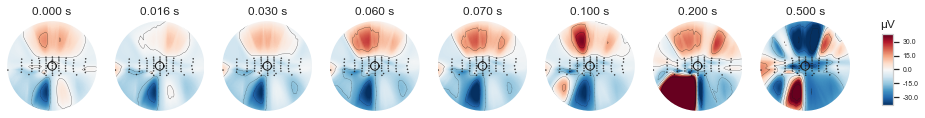

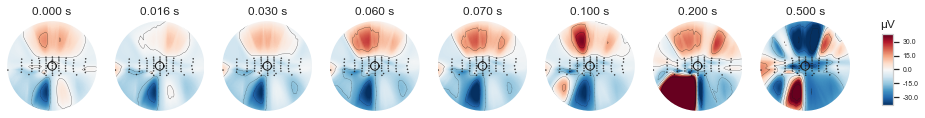

In [71]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

### Test other event type

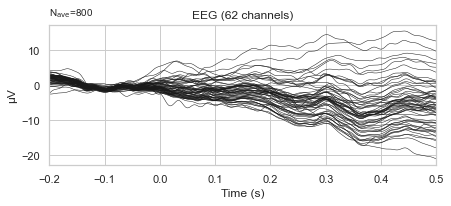

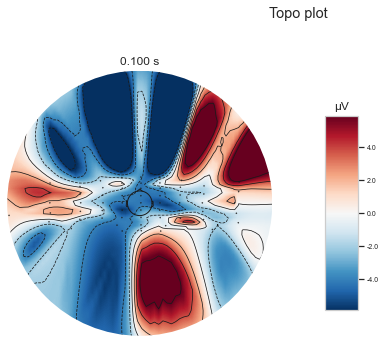

In [72]:
evoked = epochs['3'].average()
evoked.plot()
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

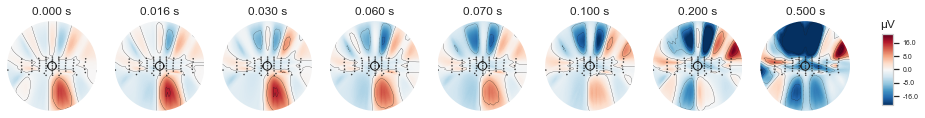

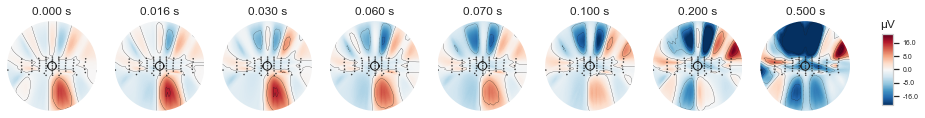

In [73]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

# Adding a montage to the data

Montages specify the exact electrode placement on the scalp of the subject. This contains coordinates relative to a point on the scalp. Often this data is included in the EEG data (.cnt file). Unfortunately for us, we don't have this information. The electrode placement information can be used to fix broken channels by using the channels surrounding this channel. Even though we don't have the exact locations, we do know the electrode placement system used: 10-20. We can use this to approximate the locations.

### When looking at the maps above, the electrode placement seems to be incorrect

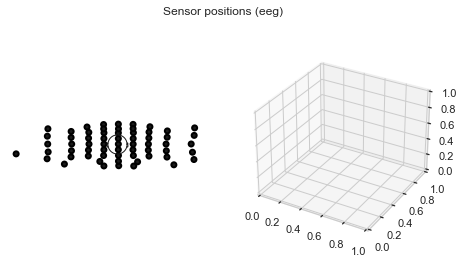

In [74]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

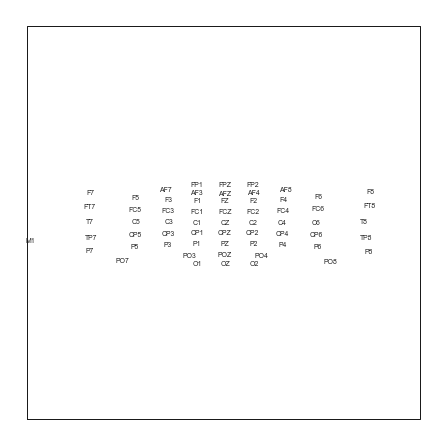

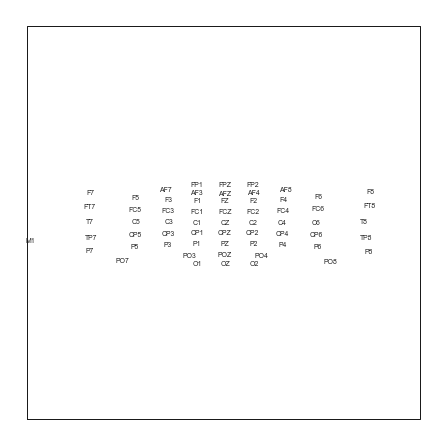

In [75]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw.info)
layout_from_raw.plot()

### Unfortunately, we don't have the exact sensor locations. Therefore, we try to approximate them with a standard montage.

Standard montages come with the mne package. They're based on well known and often used electrode placement systems (10-20 in our case).

In [76]:
print(data_raw.ch_names)

['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'HEOG', 'VEOG', 'AFZ', 'PO3', 'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']


In [77]:
len(data_raw.ch_names)

64

In [78]:
montage = mne.channels.make_standard_montage('standard_1020')
montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


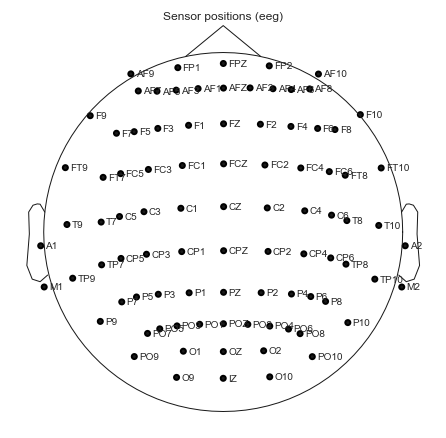

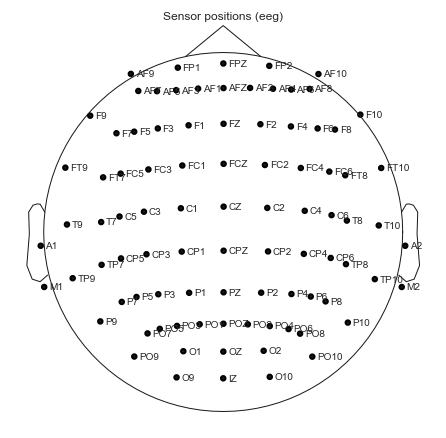

In [79]:
montage.plot(kind='topomap', show_names=True)

In [80]:
data_raw_1020 = data_raw.copy().set_montage(montage)

### Now, after setting the 1020 montage, the maps look different

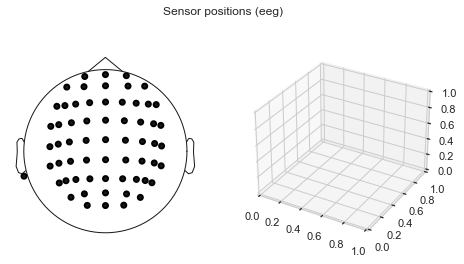

In [81]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

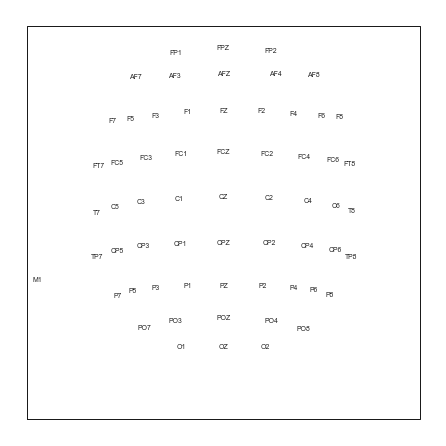

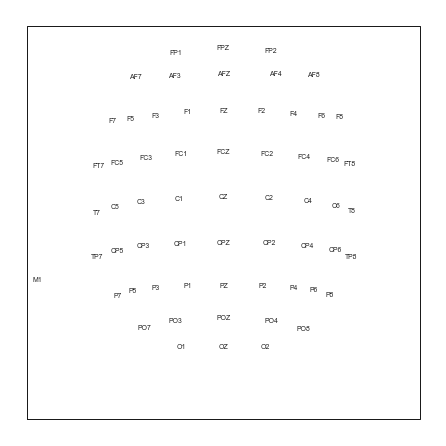

In [82]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw_1020.info)
layout_from_raw.plot()

## Custom cnt-file import function:

In [83]:
def read_cnt_file(file,
                  label_group,
                  event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2,
                  max_bad_channels = 2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501))
    label_collection = [] #np.zeros((0))
    channel_names_collection = []
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    # Get events from annotations in the data
    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
    for event_id in event_idx:
        if str(event_id) in event_dict:
            # Pick EEG channels
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, event_repeated='merge', verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs,
                                                                          event_id,
                                                                          threshold = threshold,
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            # ------------------------------------------------------------------
            if len(bad_channels) > 0:
                if len(bad_channels) > max_bad_channels:
                    print(20*'--')
                    print("Found too many bad channels (" + str(len(bad_channels)) + ")")
                    return None, None, None
                else:
                    # MARK: Setting the montage is not verified yet (choice of standard montage)
                    montage = mne.channels.make_standard_montage('standard_1020')
                    montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]
                    data_raw.set_montage(montage)
                    
                    # TODO: Think about using all channels before removing (62 -> 30), to enable for better interpolation
                    
                    # Mark bad channels:
                    data_raw.info['bads'] = bad_channels
                    # Pick EEG channels:
                    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       #exclude=data_exclude)#'bads'])
                                       include=channel_set, exclude=channels_exclude)#'bads'])
                    epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                        tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                        baseline=baseline, preload=True, verbose=False)
                    
                    # Interpolate bad channels using functionality of 'mne'
                    epochs.interpolate_bads()
                    

            # Get signals as array and add to total collection
            channel_names_collection.append(epochs.ch_names)
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0)
            label_collection += [event_id + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection, channel_names_collection

In [84]:
signal_collect, label_collect, channel_names_collection = read_cnt_file(merged_df['cnt_path'][20], 
                                                                        merged_df['age_months'][0],
                                                                        event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                                        channel_set = "30",
                                                                        tmin = -0.2,
                                                                        tmax = 0.8,
                                                                        lpass = 0.5, 
                                                                        hpass = 40, 
                                                                        threshold = 5, 
                                                                        max_bad_fraction = 0.2,
                                                                        max_bad_channels = 2)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
No outliers found with given threshold.
Found 38 bad epochs in a total of 14  channels.
Marked 38 bad epochs in a total of 560  epochs.
Found 11 bad epochs in a total of 13  channels.
Marked 11 bad epochs in a total of 400  epochs.
Found 7 bad epochs in a total of 13  channels.
Marked 7 bad epochs in a total of 400  epochs.
No outliers found with given threshold.
Found 5 bad epochs in a total of 8  channels.
Marked 5 bad epochs in a total of 70  epochs.
Found 1 bad epochs in a total of 9  channels.
Marked 1 bad epochs in a total of 50  epochs.
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.


In [85]:
signal_collect.shape

(1917, 30, 501)

In [86]:
len(label_collect)

1917

In [90]:
signal_collect.shape #, label_collect.shape

(1917, 30, 501)

In [92]:
# metadata_collection[:10]

# Feature extraction and save processed data

## Determine how to store the processed data

Below we're determining what the best method is to extract and save the features. At the end, we combine all the parts.

In [94]:
local_processed_data4 = 'C:/Projects/EEG_explorer/Data/data_processed_ML4'

In [ ]:
for i, file in merged_df.iterrows():
    
    # Import data and labels
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
        
    # Save data and labels
    # ---------------------------------------------------------
#     if signal_collect is None:
#         continue

    # Firstly, save the metadata which will be the same for all files derived from this .cnt file
    filename_metadata = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".csv")
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)        
    
    # Save all the epochs to separate files
    filename_signal = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".npy")
    np.save(filename_signal, signal_collect)
    
    #break # MARK: Remove this!

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Found 220 bad epochs in a total of 27  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 66 bad epochs in a total of 360  epochs.
Found 311 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  8
Marked 200 bad epochs in a total of 360  epochs.
----------------------------------------
Found too many bad channels (3)
Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 110 ba

Found 23 bad epochs in a total of 4  channels.
Marked 23 bad epochs in a total of 400  epochs.
Found 44 bad epochs in a total of 8  channels.
Marked 44 bad epochs in a total of 400  epochs.
Found 11 bad epochs in a total of 18  channels.
Marked 11 bad epochs in a total of 400  epochs.
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 50  epochs.
Found 1 bad epochs in a total of 2  channels.
Marked 1 bad epochs in a total of 50  epochs.
Found 3 bad epochs in a total of 6  channels.
Marked 3 bad epochs in a total of 50  epochs.
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Used Annotations descriptions: ['0', '13', '3', '66']
Found 95 bad epochs in a total of 30  channels.
Marked 95 bad epochs in a total of 400  epochs.
Found 10 bad epochs in a total of 7  channels.
Marked 10 bad epochs in a total of 50  epochs.
Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 122 bad epochs in a total

## Extract features that can be used for machine learning models

In [337]:
from mne_features.feature_extraction import extract_features

### Extract features from the raw data to reduce dimensionality

In [339]:
# User defined functions

def compute_rms(data):
    """Root-mean squared value of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: *rms*
    """
    return np.sqrt(np.mean(np.power(data, 2), axis=-1))

In [340]:
# Select features from the raw data for machine learning
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'std', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq', 'ptp_amp'}

X_new = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)

In [341]:
X_new

app_entropy                                                              \
               0         1         2         3         4         5         6   
0       0.238545  0.091919  0.154671  0.211356  0.183087  0.263689  0.257679   
1       0.114495  0.137796  0.129438  0.123613  0.158240  0.201478  0.056816   
2       0.109270  0.317358  0.176161  0.376019  0.448188  0.380659  0.358159   
3       0.232889  0.122093  0.238334  0.240812  0.237854  0.342609  0.160202   
4       0.161619  0.169864  0.157296  0.196510  0.193108  0.257671  0.103481   
...          ...       ...       ...       ...       ...       ...       ...   
1912    0.130113  0.319262  0.218527  0.111123  0.141057  0.128091  0.191526   
1913    0.242157  0.323631  0.210402  0.339576  0.439564  0.431538  0.436809   
1914    0.402099  0.316161  0.325321  0.513700  0.456661  0.512545  0.507213   
1915    0.362851  0.409583  0.361026  0.489894  0.509988  0.537576  0.516636   
1916    0.198753  0.203307  0.178329  0.269479  0.353094  0.230084  0.320594   

                                    ...      variance                \
             7         8         9  ...            20            21   
0     0.313831  0.274405  0.217948  ...  1.810441e-09  1.635468e-09   
1     0.204097  0.296655  0.266097  ...  3.380027e-09  3.073718e-09   
2     0.397713  0.410179  0.283444  ...  1.020609e-09  1.600384e-09   
3     0.287921  0.325484  0.202503  ...  5.784338e-09  3.193887e-09   
4     0.168587  0.384513  0.217749  ...  1.824343e-09  1.978543e-09   
...        ...       ...       ...  ...           ...           ...   
1912  0.150052  0.125422  0.141045  ...  3.167664e-09  2.596098e-09   
1913  0.344828  0.434452  0.373432  ...  5.660643e-09  2.214916e-09   
1914  0.528236  0.493121  0.488644  ...  2.412095e-09  1.288985e-09   
1915  0.545889  0.444416  0.370453  ...  9.088845e-10  1.116382e-09   
1916  0.158404  0.327174  0.259937  ...  3.966216e-09  1.611600e-09   

                                                                            \
                22            23            24            25            26   
0     5.854615e-10  1.121837e-09  1.918300e-09  8.992467e-10  9.924160e-10   
1     6.686697e-10  1.340321e-09  7.679324e-10  3.891178e-09  3.228367e-09   
2     1.112954e-09  4.056475e-10  9.701136e-10  1.686688e-09  1.498968e-09   
3     2.736702e-09  4.689736e-10  1.633371e-09  2.548626e-09  4.306804e-09   
4     1.721026e-09  2.256340e-09  1.644724e-09  2.138191e-09  1.889972e-09   
...            ...           ...           ...           ...           ...   
1912  9.517417e-10  1.823453e-09  1.781714e-09  2.116139e-09  3.071554e-09   
1913  2.492277e-09  6.898088e-10  6.807023e-10  2.995289e-09  2.674433e-09   
1914  5.495694e-10  4.609519e-10  4.610586e-10  6.389534e-10  4.995414e-10   
1915  6.910916e-10  1.711689e-09  1.757996e-09  7.067228e-10  1.297859e-09   
1916  2.656019e-09  2.919463e-09  2.693653e-09  1.349205e-09  1.454545e-09   

                                                
                27            28            29  
0     9.935596e-10  6.519150e-10  1.025606e-09  
1     8.129441e-10  9.445677e-10  7.872683e-10  
2     3.335303e-09  1.524923e-09  1.488996e-09  
3     3.605006e-09  1.762073e-09  4.396485e-09  
4     1.273477e-09  1.426712e-09  1.830422e-09  
...            ...           ...           ...  
1912  2.848659e-09  1.185528e-09  2.637064e-09  
1913  6.783166e-10  2.578894e-09  2.219024e-09  
1914  6.195881e-10  6.589380e-10  3.730510e-10  
1915  1.106763e-09  1.104257e-09  1.354031e-09  
1916  1.478485e-09  5.293073e-10  1.470733e-09  

[1917 rows x 510 columns]

The raw data had a shape of (1917, 30, 501) - the extracted features data is almost 30 times smaller (before feature selection):

In [342]:
X_new.shape

(1917, 510)

### Search for highly correlated features and remove one of them

Some features are often highly correlated and therefore don't add a lot of additional information to the model. To further reduce dimensionality, one of the two highly correlated features can be removed.

In [343]:
X_new_1 = X_new.iloc[:, X_new.columns.get_level_values(1)=='1']

In [344]:
# Select only the first channel for all features

X_new_1

,app_entropy,hjorth_mobility,mean,hjorth_complexity,spect_edge_freq,root_mean_squared,std,zero_crossings,skewness,kurtosis,ptp_amp,variance
,1,1,1,1,1,1,1,1,1,1,1,1
0,0.091919,0.032548,0.000081,17.138237,1.953125,0.000112,0.000077,4.0,-0.344565,1.916585,0.000283,5.944649e-09
1,0.137796,0.061360,0.000081,18.221765,1.953125,0.000101,0.000060,2.0,-0.198043,1.955404,0.000239,3.592105e-09
2,0.317358,0.086308,0.000022,8.808040,1.953125,0.000041,0.000035,6.0,-0.081688,2.073234,0.000143,1.224372e-09
3,0.122093,0.042056,0.000042,16.780888,1.953125,0.000078,0.000065,6.0,0.033635,1.712878,0.000223,4.231386e-09
4,0.169864,0.048407,0.000003,6.479967,1.953125,0.000058,0.000058,8.0,0.846689,3.161951,0.000247,3.409689e-09
...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.319262,0.133269,0.000005,8.741181,3.906250,0.000028,0.000027,15.0,0.207828,2.999758,0.000140,7.305596e-10
1913,0.323631,0.085499,0.000013,6.718509,3.906250,0.000029,0.000026,13.0,-0.033306,2.336701,0.000111,6.612563e-10
1914,0.316161,0.081335,0.000014,4.762174,1.953125,0.000041,0.000039,15.0,0.284651,2.135239,0.000151,1.491505e-09


In [345]:
correlation = X_new_1.corr()

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

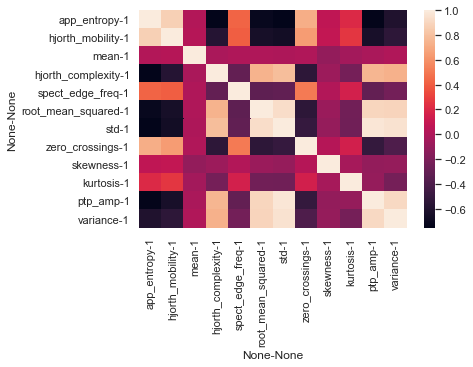

In [346]:
sns.heatmap(correlation)

In [347]:
correlation

,,app_entropy,hjorth_mobility,mean,hjorth_complexity,spect_edge_freq,root_mean_squared,std,zero_crossings,skewness,kurtosis,ptp_amp,variance
,,1,1,1,1,1,1,1,1,1,1,1,1
app_entropy,1,1.000000,0.875983,0.018051,-0.751942,0.430390,-0.712485,-0.753154,0.725985,0.070334,0.211590,-0.745300,-0.604471
hjorth_mobility,1,0.875983,1.000000,0.031077,-0.575511,0.408838,-0.649936,-0.669751,0.644568,0.083649,0.261440,-0.636843,-0.543033
mean,1,0.018051,0.031077,1.000000,-0.014642,0.000402,0.001058,-0.001965,0.011312,-0.106637,-0.041992,-0.014256,0.009272
hjorth_complexity,1,-0.751942,-0.575511,-0.014642,1.000000,-0.306947,0.740372,0.789058,-0.542929,-0.074765,-0.231068,0.756886,0.735143
spect_edge_freq,1,0.430390,0.408838,0.000402,-0.306947,1.000000,-0.322788,-0.308196,0.509080,0.016677,0.158368,-0.303235,-0.238557
root_mean_squared,1,-0.712485,-0.649936,0.001058,0.740372,-0.322788,1.000000,0.933755,-0.546626,-0.077463,-0.244893,0.902397,0.890430
std,1,-0.753154,-0.669751,-0.001965,0.789058,-0.308196,0.933755,1.000000,-0.505538,-0.099924,-0.251711,0.973124,0.957468
zero_crossings,1,0.725985,0.644568,0.011312,-0.542929,0.509080,-0.546626,-0.505538,1.000000,0.033465,0.153359,-0.511381,-0.393550
skewness,1,0.070334,0.083649,-0.106637,-0.074765,0.016677,-0.077463,-0.099924,0.033465,1.000000,-0.030846,-0.103254,-0.096051


In [348]:
correlation.ge(0.9)

"""
Highly correlated (>0.90), channel 0:
- std & rms (0.926)
- std & ptp_amp (0.9688)
- std & variance (0.952)
- ptp_amp & variance (0.900)

Highly correlated (>0.90), channel 1:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 2:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 4:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 5:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance
"""

'\nHighly correlated (>0.90), channel 0:\n- std & rms (0.926)\n- std & ptp_amp (0.9688)\n- std & variance (0.952)\n- ptp_amp & variance (0.900)\n\nHighly correlated (>0.90), channel 1:\nstd & rms\nstd & ptp_amp\nstd & variance\nrms & ptp_amp\nptp_amp & variance\n\nHighly correlated (>0.90), channel 2:\nstd & rms\nstd & ptp_amp\nstd & variance\nrms & ptp_amp\nptp_amp & variance\n\nHighly correlated (>0.90), channel 3:\nstd & rms\nstd & ptp_amp\nstd & variance\nptp_amp & variance\n\nHighly correlated (>0.90), channel 3:\nstd & rms\nstd & ptp_amp\nstd & variance\nptp_amp & variance\n\nHighly correlated (>0.90), channel 4:\nstd & rms\nstd & ptp_amp\nstd & variance\nptp_amp & variance\n\nHighly correlated (>0.90), channel 5:\nstd & rms\nstd & ptp_amp\nstd & variance\nrms & ptp_amp\nptp_amp & variance\n'

After inspecting a few channels and the correlation between the features, the features 'std' and 'ptp_amp' can be removed, because they have a high correlation with eachother, 'rms' and 'variance'. Removing these two features will reduce the dimensionality.

### Feature extraction after selection

In [349]:
# Removed features: std, ptp_amp
selected_features_selection = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq'}

X_new_selection = extract_features(signal_collect, 500.0, selected_features_selection, return_as_df=1)

In [350]:
X_new_selection.columns

MultiIndex([('app_entropy',  '0'),
            ('app_entropy',  '1'),
            ('app_entropy',  '2'),
            ('app_entropy',  '3'),
            ('app_entropy',  '4'),
            ('app_entropy',  '5'),
            ('app_entropy',  '6'),
            ('app_entropy',  '7'),
            ('app_entropy',  '8'),
            ('app_entropy',  '9'),
            ...
            (   'variance', '20'),
            (   'variance', '21'),
            (   'variance', '22'),
            (   'variance', '23'),
            (   'variance', '24'),
            (   'variance', '25'),
            (   'variance', '26'),
            (   'variance', '27'),
            (   'variance', '28'),
            (   'variance', '29')],
           length=450)

The different channels aren't identifiable by the current naming method. Map the numbers to the actual channel name and flatten the MultiIndex column dataframe.

In [352]:
# Update the column names

import re

cols = []

for i, j in X_new_selection.columns:
    try:
        cols.append(f'{i}_{channel_names_collection[0][int(j)]}')
    except ValueError:
        # energy_freq_bands features
        str_parts = j.split('_')        
        ch_num = re.findall("\d+", str_parts[0])[0]
        cols.append(f'{i}_{str_parts[1]}_{channel_names_collection[0][int(ch_num)]}')
        
X_new_selection.columns = cols

In [353]:
for i in X_new_selection.columns:
    print(i)

app_entropy_O2
app_entropy_O1
app_entropy_OZ
app_entropy_PZ
app_entropy_P4
app_entropy_CP4
app_entropy_P8
app_entropy_C4
app_entropy_TP8
app_entropy_T8
app_entropy_P7
app_entropy_P3
app_entropy_CP3
app_entropy_CPZ
app_entropy_CZ
app_entropy_FC4
app_entropy_FT8
app_entropy_TP7
app_entropy_C3
app_entropy_FCZ
app_entropy_FZ
app_entropy_F4
app_entropy_F8
app_entropy_T7
app_entropy_FT7
app_entropy_FC3
app_entropy_F3
app_entropy_FP2
app_entropy_F7
app_entropy_FP1
energy_freq_bands_band0_O2
energy_freq_bands_band1_O2
energy_freq_bands_band2_O2
energy_freq_bands_band3_O2
energy_freq_bands_band4_O2
energy_freq_bands_band0_O1
energy_freq_bands_band1_O1
energy_freq_bands_band2_O1
energy_freq_bands_band3_O1
energy_freq_bands_band4_O1
energy_freq_bands_band0_OZ
energy_freq_bands_band1_OZ
energy_freq_bands_band2_OZ
energy_freq_bands_band3_OZ
energy_freq_bands_band4_OZ
energy_freq_bands_band0_PZ
energy_freq_bands_band1_PZ
energy_freq_bands_band2_PZ
energy_freq_bands_band3_PZ
energy_freq_bands_band4_P

# Putting the feature extraction, selection and saving steps together

Steps:

1. Check if files don't already exist
2. Load EEG data
3. Extract features
4. Save metadata, save features dataframe

In [371]:
import re
from itertools import islice

# TODO: Check the band ranges used
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq'}

for i, file in islice(merged_df.iterrows(), 0, None): # Enables you to set starting row of DataFrame
    print(f"Checking out file: {file['cnt_file']}")
        
    filename_extracted_features = os.path.join(PATH_DATA_PROCESSED_ML, "extracted_features_" + file['cnt_file'] + ".h5")
    filename_metadata = os.path.join(PATH_DATA_PROCESSED_ML, "processed_data_" + file['cnt_file'] + ".csv")
    
    # Step 1: Check if file don't already exist, else skip
    if os.path.exists(filename_extracted_features) and os.path.exists(filename_metadata):
        print(f"Skipping because {filename_extracted_features} and {filename_metadata} already exist.")
        continue
    
    
    # Step 2: Import data and labels 
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
    
    if signal_collect is None:
        continue
    
    # Step 3: Extract the features from the raw data
    try:
        extracted_features = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)
    except:
        print(f"Skipping because {file['cnt_file']} causes error when extracting features.")
        continue
    
    # Change the DataFrame from hierarchical column structure ('mean' -> ch1, ch2, ch3) 
    # to flat column structure ('mean-ch1', 'mean-ch2', etc..)
    col_names = []

    for i, j in extracted_features.columns:
        try:
            col_names.append(f'{i}_{channel_names_collection[0][int(j)]}')
        except ValueError:
            # energy_freq_bands feature has different naming
            str_parts = j.split('_')        
            ch_num = re.findall("\d+", str_parts[0])[0]
            col_names.append(f'{i}_{str_parts[1]}_{channel_names_collection[0][int(ch_num)]}')
        
    extracted_features.columns = col_names
    
    # Step 4: Save metadata (same for all files derived from this .cnt file), save the extracted features
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)     
    extracted_features.to_hdf(filename_extracted_features, key='df', mode='w')
    # TODO: 1. Try saving 2. Retry after n seconds if fails 3. If fails m times, continue

Checking out file: 406_29_md_mmn_baep_down_wk
Reading 0 ... 4031999  =      0.000 ...   201.600 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 132001 samples (6.600 sec)

Used Annotations descriptions: ['1']
Skipping because 406_29_md_mmn_baep_down_wk causes error when extracting features.
Checking out file: 406_29_md_mmn_baep_up_wk
Reading 0 ... 4187199  =      0.000 ...   209.360 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parame


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
No outliers found with given threshold.
No outliers found with given threshold.
Checking out file: 409_29_jd_mmn36_wk
Reading 0 ... 362259  =      0.000 ...   724.518 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB st


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 67 bad epochs in a total of 8  channels.
Marked 67 bad epochs in a total of 800  epochs.
Found 13 bad epochs in a total of 4  channels.
Marked 13 bad epochs in a total of 100  epochs.
Checking out file: 422_29_jd_mmn36_slp
Reading 0 ... 726219  =      0.000 ...  1452.438 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal band

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 51 bad epochs in a total of 19  channels.
Marked 51 bad epochs in a total of 800  epochs.
Found 3 bad epochs in a total of 1  channels.
Marked 3 bad epochs in a total of 100  epochs.
Checking out file: 430_29_md_mmn25_wk
Reading 0 ... 735559  =      0.000 ...  1471.118 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Design

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 15 bad epochs in a total of 5  channels.
Marked 15 bad epochs in a total of 800  epochs.
Found 5 bad epochs in a total of 3  channels.
Marked 5 bad epochs in a total of 100  epochs.
Checking out file: 438_29_jd_mmn25_wk
Reading 0 ... 728519  =      0.000 ...  1457.038 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 66 bad epochs in a total of 10  channels.
Marked 66 bad epochs in a total of 400  epochs.
Found 9 bad epochs in a total of 2  channels.
Marked 9 bad epochs in a total of 50  epochs.
Checking out file: 445_29_md_mmn36_wk
Reading 0 ... 728659  =      0.000 ...  1457.318 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 H

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 156 bad epochs in a total of 30  channels.
Marked 156 bad epochs in a total of 800  epochs.
Found 19 bad epochs in a total of 8  channels.
Marked 19 bad epochs in a total of 100  epochs.
Checking out file: 452_29_jd_mmn36_mix
Reading 0 ... 724899  =      0.000 ...  1449.798 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple 

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 44 bad epochs in a total of 30  channels.
Marked 44 bad epochs in a total of 800  epochs.
Found 6 bad epochs in a total of 3  channels.
Marked 6 bad epochs in a total of 100  epochs.
Checking out file: 457_29_jd_mmn25_wk
Reading 0 ... 725439  =      0.000 ...  1450.878 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fir

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 40 bad epochs in a total of 15  channels.
Marked 40 bad epochs in a total of 800  epochs.
Found 9 bad epochs in a total of 30  channels.
Marked 9 bad epochs in a total of 100  epochs.
Checking out file: 471_29_md_mmn25_wk
Reading 0 ... 362779  =      0.000 ...   725.558 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 11 bad epochs in a total of 5  channels.
Marked 11 bad epochs in a total of 800  epochs.
No outliers found with given threshold.
Checking out file: 603-124-29m-jc-mmn36-waak
Reading 0 ... 746519  =      0.000 ...  1493.038 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 

Found 20 bad epochs in a total of 9  channels.
Marked 20 bad epochs in a total of 800  epochs.
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 100  epochs.
Checking out file: 609-158-29m-jc-mmn36
Reading 0 ... 1116539  =      0.000 ...  2233.078 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 109 bad epochs in a total of 29  channels.
Marked 109 bad epochs in a total of 1200  epo

Found 19 bad epochs in a total of 10  channels.
Marked 19 bad epochs in a total of 118  epochs.
Checking out file: 617-289-29m-mc-mmn36
Reading 0 ... 536159  =      0.000 ...  1072.318 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 451 bad epochs in a total of 3  channels.
Found bad channel (more than 112.60000000000001  bad epochs): Channel no:  8
Marked 7 bad epochs in a total of 563  epochs.
Found 59 bad epochs 

Checking out file: 625-253-29m-jc-mmn36
Reading 0 ... 624579  =      0.000 ...  1249.158 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 97 bad epochs in a total of 23  channels.
Marked 97 bad epochs in a total of 679  epochs.
Found 11 bad epochs in a total of 11  channels.
Marked 11 bad epochs in a total of 83  epochs.
Checking out file: 626-377-29m-jc-mmn36
Reading 0 ... 744019  =      0.000 ...  1488.038 secs...



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 160 bad epochs in a total of 15  channels.
Marked 160 bad epochs in a total of 800  epochs.
Found 22 bad epochs in a total of 7  channels.
Marked 22 bad epochs in a total of 100  epochs.
Checking out file: 637-479-29m-mc-mmn36
Reading 0 ... 739219  =      0.000 ...  1478.438 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 80  epochs.
No outliers found with given threshold.
Checking out file: 701-008-29m-jr-mmn_25
Reading 0 ... 368559  =      0.000 ...   737.118 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 20 bad epochs in a total of 29  channels.
Marked 20 bad epochs in a total of 480  epochs.
Found 3 bad epochs in a total of 8  channels.
Marked 3 bad epochs in a total of 60  epochs.
Checking out file: 707-060-29m-jr-mmn25-waak
Reading 0 ... 367759  =      0.000 ...   735.518 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequ

Found 10 bad epochs in a total of 5  channels.
Marked 10 bad epochs in a total of 400  epochs.
No outliers found with given threshold.
Checking out file: 710-078-29m-jr-mmn36dummy
Reading 0 ... 367539  =      0.000 ...   735.078 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 18 bad epochs in a total of 12  channels.
Marked 18 bad epochs in a total of 400  epochs.
Found 2 bad epochs in a total of 1  channels.
M

Found 35 bad epochs in a total of 30  channels.
Marked 35 bad epochs in a total of 800  epochs.
Found 5 bad epochs in a total of 5  channels.
Marked 5 bad epochs in a total of 100  epochs.
Checking out file: 715-090-29m-mr-mmn36
Reading 0 ... 619899  =      0.000 ...  1239.798 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 139 bad epochs in a total of 30  channels.
Marked 139 bad epochs in a total of 663  epoc

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 45 bad epochs in a total of 30  channels.
Marked 45 bad epochs in a total of 880  epochs.
Found 6 bad epochs in a total of 17  channels.
Marked 6 bad epochs in a total of 110  epochs.
Checking out file: 721-106-29m-mr-mmn36-b
Reading 0 ... 424319  =      0.000 ...   848.638 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR fil

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 91 bad epochs in a total of 26  channels.
Marked 91 bad epochs in a total of 1121  epochs.
Found 12 bad epochs in a total of 7  channels.
Marked 12 bad epochs in a total of 138  epochs.
Checking out file: 726-126-29m-jr-mmn36-1
Reading 0 ... 452439  =      0.000 ...   904.878 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 43 bad epochs in a total of 30  channels.
Marked 43 bad epochs in a total of 761  epochs.
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 94  epochs.
Checking out file: 731-197-29m-jr-mmn36-waak
Reading 0 ... 740879  =      0.000 ...  1481.758 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency:


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 372 bad epochs in a total of 10  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  0
Marked 21 bad epochs in a total of 800  epochs.
Found 45 bad epochs in a total of 30  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  0
Marked 3 bad epochs in a total of 100  epochs.
Checking out file: 744-352-29m-mr-mmn36
Reading 0 ... 739759  =      0.000 ...  1479.518 secs...
Filtering raw data in 1 contiguous segment
Setting up ban


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 63 bad epochs in a total of 30  channels.
Marked 63 bad epochs in a total of 800  epochs.
Found 8 bad epochs in a total of 14  channels.
Marked 8 bad epochs in a total of 100  epochs.
Checking out file: 753-470-29m-mr-mmn36
Reading 0 ... 750239  =      0.000 ...  1500.478 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ban

Checking out file: 008_35_jc_mmn36_wk
Reading 0 ... 754399  =      0.000 ...  1508.798 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 41 bad epochs in a total of 15  channels.
Marked 41 bad epochs in a total of 800  epochs.
Found 7 bad epochs in a total of 7  channels.
Marked 7 bad epochs in a total of 100  epochs.
Checking out file: 009_35_jc_mmn36_wk
Reading 0 ... 748679  =      0.000 ...  1497.358 secs...
Filter


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 910 bad epochs in a total of 29  channels.
Found bad channel (more than 289.6  bad epochs): Channel no:  9
Found bad channel (more than 289.6  bad epochs): Channel no:  6
Marked 614 bad epochs in a total of 1448  epochs.
Found 118 bad epochs in a total of 22  channels.
Found bad channel (more than 36.2  bad epochs): Channel no:  9
Found bad channel (more than 36.2  bad epochs): Channel no:  6
Marked 94 bad epochs in a total of 181  epochs.
Checking out file:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 8 bad epochs in a total of 8  channels.
Marked 8 bad epochs in a total of 400  epochs.
Found 2 bad epochs in a total of 5  channels.
Marked 2 bad epochs in a total of 50  epochs.
Checking out file: 034_35_mc_mmn36_wk
Reading 0 ... 377619  =      0.000 ...   755.238 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter param

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 89 bad epochs in a total of 2  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 1 bad epochs in a total of 400  epochs.
Found 11 bad epochs in a total of 1  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 0 bad epochs in a total of 50  epochs.
Checking out file: 103_35_mr_mmn36_wk
Reading 0 ... 368719  =      0.000 ...   737.438 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-c

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 60 bad epochs in a total of 19  channels.
Marked 60 bad epochs in a total of 473  epochs.
Found 7 bad epochs in a total of 11  channels.
Marked 7 bad epochs in a total of 60  epochs.
Checking out file: 108_35_jr_mmn36_wk_2
Reading 0 ... 89939  =      0.000 ...   179.878 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 18 bad epochs in a total of 12  channels.
Marked 18 bad epochs in a total of 400  epochs.
Found 3 bad epochs in a total of 5  channels.
Marked 3 bad epochs in a total of 50  epochs.
Checking out file: 115_35_mr_mmn36_wk
Reading 0 ... 369799  =      0.000 ...   739.598 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- 

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 238 bad epochs in a total of 25  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  8
Marked 29 bad epochs in a total of 800  epochs.
Found 35 bad epochs in a total of 17  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  8
Marked 5 bad epochs in a total of 100  epochs.
Checking out file: 128_35_jr_mmn36_wk
Reading 0 ... 803559  =      0.000 ...  1607.118 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['1', '12', '13', '33']
Found 6 bad epochs in a total of 5  channels.
Marked 6 bad epochs in a total of 50  epochs.
Found 5 bad epochs in a total of 6  channels.
Marked 5 bad epochs in a total of 50  epochs.
Checking out file: 139_35_mr_mmn36_wk
Reading 0 ... 742919  =      0.000 ...  1485.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)


Reading 0 ... 370019  =      0.000 ...   740.038 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 68 bad epochs in a total of 13  channels.
Marked 68 bad epochs in a total of 400  epochs.
Found 5 bad epochs in a total of 5  channels.
Marked 5 bad epochs in a total of 50  epochs.
Checking out file: 148_35_mr_mmn36_wk
Reading 0 ... 377339  =      0.000 ...   754.678 secs...
Filtering raw data in 1 contiguous segment
Se

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 30 bad epochs in a total of 26  channels.
Marked 30 bad epochs in a total of 800  epochs.
Found 4 bad epochs in a total of 6  channels.
Marked 4 bad epochs in a total of 100  epochs.
Checking out file: 156_35_jr_mmn36_wk
Reading 0 ... 755819  =      0.000 ...  1511.638 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 60 

Reading 0 ... 386439  =      0.000 ...   772.878 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
No outliers found with given threshold.
No outliers found with given threshold.
Checking out file: 170_35_mr_mmn36_wk
Reading 0 ... 542479  =      0.000 ...  1084.958 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass

Reading 0 ... 369599  =      0.000 ...   739.198 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 5 bad epochs in a total of 4  channels.
Marked 5 bad epochs in a total of 400  epochs.
No outliers found with given threshold.
Checking out file: 178_35_jr_mmn36_wk
Reading 0 ... 378459  =      0.000 ...   756.918 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter 

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 23 bad epochs in a total of 14  channels.
Marked 23 bad epochs in a total of 800  epochs.
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Checking out file: 305_35_jc_mmn36_wk
Reading 0 ... 728019  =      0.000 ...  1456.038 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed t


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['1', '12', '13', '33']
Found 31 bad epochs in a total of 20  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 19 bad epochs in a total of 50  epochs.
Found 25 bad epochs in a total of 11  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 7 bad epochs in a total of 50  epochs.
Checking out file: 311_35_jc_mmn25_wk
Reading 0 ... 724639  =      0.000 ...  1449.278 secs...
Filtering raw data in 1 contiguous segment
Setting up ban


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 20 bad epochs in a total of 10  channels.
Marked 20 bad epochs in a total of 800  epochs.
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 100  epochs.
Checking out file: 316_35_mc_mmn36_wk
Reading 0 ... 728159  =      0.000 ...  1456.318 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpa

Checking out file: 325_35_mc_mmn36_wk
Reading 0 ... 593079  =      0.000 ...  1186.158 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 53 bad epochs in a total of 30  channels.
Marked 53 bad epochs in a total of 651  epochs.
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 82  epochs.
Checking out file: 326_35_jc_mmn25_wk
Reading 0 ... 725879  =      0.000 ...  1451.758 secs...
Filteri

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 124 bad epochs in a total of 30  channels.
Marked 124 bad epochs in a total of 400  epochs.
Found 10 bad epochs in a total of 30  channels.
Marked 10 bad epochs in a total of 50  epochs.
Checking out file: 343_35_mc_mmn36_wk
Reading 0 ... 732219  =      0.000 ...  1464.438 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filt

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 69 bad epochs in a total of 8  channels.
Marked 69 bad epochs in a total of 800  epochs.
Found 10 bad epochs in a total of 4  channels.
Marked 10 bad epochs in a total of 100  epochs.
Checking out file: 348_35_jc_mmn6_wk
Reading 0 ... 726339  =      0.000 ...  1452.678 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 11 

Found 14 bad epochs in a total of 8  channels.
Marked 14 bad epochs in a total of 100  epochs.
Checking out file: 409_35_jd_mmn36_wk
Reading 0 ... 903239  =      0.000 ...  1806.478 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 80 bad epochs in a total of 12  channels.
Marked 80 bad epochs in a total of 995  epochs.
Found 13 bad epochs in a total of 7  channels.
Marked 13 bad epochs in a total of 125  epochs.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 92 bad epochs in a total of 22  channels.
Marked 92 bad epochs in a total of 481  epochs.
Found 14 bad epochs in a total of 18  channels.
Marked 14 bad epochs in a total of 62  epochs.
Checking out file: 414_35_jd_mmn36_wk
Reading 0 ... 724139  =      0.000 ...  1448.278 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR f

Reading 0 ... 723279  =      0.000 ...  1446.558 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 30 bad epochs in a total of 19  channels.
Marked 30 bad epochs in a total of 800  epochs.
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 100  epochs.
Checking out file: 426_35_jd_mmn36_wk
Reading 0 ... 723299  =      0.000 ...  1446.598 secs...
Filtering raw data in 1 contiguous segm

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 17 bad epochs in a total of 5  channels.
Marked 17 bad epochs in a total of 800  epochs.
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Checking out file: 433_35_jd_mmn25_slp
Reading 0 ... 726339  =      0.000 ...  1452.678 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR fil

Checking out file: 438_35_jd_mmn25_wk
Reading 0 ... 432299  =      0.000 ...   864.598 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 23 bad epochs in a total of 10  channels.
Marked 23 bad epochs in a total of 435  epochs.
Found 5 bad epochs in a total of 18  channels.
Marked 5 bad epochs in a total of 55  epochs.
Checking out file: 438_35_jd_mmn36_wk
Reading 0 ... 725179  =      0.000 ...  1450.358 secs...
F

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 52 bad epochs in a total of 9  channels.
Marked 52 bad epochs in a total of 795  epochs.
Found 4 bad epochs in a total of 1  channels.
Marked 4 bad epochs in a total of 100  epochs.
Checking out file: 445_35_md_mmn36_wk
Reading 0 ... 731099  =      0.000 ...  1462.198 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter pa


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 5 bad epochs in a total of 8  channels.
Marked 5 bad epochs in a total of 800  epochs.
No outliers found with given threshold.
Checking out file: 465_35_jd_mmn25_wk
Reading 0 ... 730579  =      0.000 ...  1461.158 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 32 bad epochs in a total of 23  channels.
Marked 32 bad epochs in a total of 800  epochs.
Found 5 bad epochs in a total of 13  channels.
Marked 5 bad epochs in a total of 100  epochs.
Checking out file: 478_35_jd_mmn36_wk
Reading 0 ... 726959  =      0.000 ...  1453.918 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.0


Used Annotations descriptions: ['0', '13', '3', '66']
Found 26 bad epochs in a total of 5  channels.
Marked 26 bad epochs in a total of 800  epochs.
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 100  epochs.
Checking out file: 486_35_jd_mmn25_wk
Reading 0 ... 728839  =      0.000 ...  1457.678 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 453 bad epochs in a total of 30  channels

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 799  epochs.
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Checking out file: 493_35_md_mmn25_wk
Reading 0 ... 745039  =      0.000 ...  1490.078 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz


Used Annotations descriptions: ['13', '3', '66']
Found 66 bad epochs in a total of 18  channels.
Marked 66 bad epochs in a total of 800  epochs.
Found 14 bad epochs in a total of 14  channels.
Marked 14 bad epochs in a total of 100  epochs.
Checking out file: 601-109-35m-jc-mmn36
Reading 0 ... 374199  =      0.000 ...   748.398 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 62 bad epochs in a total of 30  channels

Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a total of 100  epochs.
Checking out file: 004_41_mc_mmn36_wk
Reading 0 ... 319739  =      0.000 ...   639.478 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 348 bad epochs in a total of 30  channels.
Found bad channel (more than 69.60000000000001  bad epochs): Channel no:  1
Found bad channel (more than 69.60000000000001  bad epochs): Channe


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
No outliers found with given threshold.
No outliers found with given threshold.
Checking out file: 010_41_jc_mmn36_wk
Reading 0 ... 739219  =      0.000 ...  1478.438 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB st

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 7 bad epochs in a total of 9  channels.
Marked 7 bad epochs in a total of 600  epochs.
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 150  epochs.
Checking out file: 021_41_jc_mmn39_380_slp
Reading 0 ... 463979  =      0.000 ...   927.958 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.0


Used Annotations descriptions: ['13', '3', '99']
Found 22 bad epochs in a total of 14  channels.
Marked 22 bad epochs in a total of 372  epochs.
Found 4 bad epochs in a total of 30  channels.
Marked 4 bad epochs in a total of 92  epochs.
Checking out file: 029_41_mc_mmn39_380
Reading 0 ... 481479  =      0.000 ...   962.958 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 8 bad epochs in a total of 16  channels.
Mar

Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 150  epochs.
Checking out file: 040_41_jc_mmn36_wk
Reading 0 ... 746219  =      0.000 ...  1492.438 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 5 bad epochs in a total of 7  channels.
Marked 5 bad epochs in a total of 800  epochs.
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Checking ou

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 27 bad epochs in a total of 13  channels.
Marked 27 bad epochs in a total of 400  epochs.
Found 2 bad epochs in a total of 7  channels.
Marked 2 bad epochs in a total of 50  epochs.
Checking out file: 108_41_jr_mmn36_wk
Reading 0 ... 373979  =      0.000 ...   747.958 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter pa

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 775 bad epochs in a total of 26  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  8
Found bad channel (more than 160.0  bad epochs): Channel no:  6
Marked 86 bad epochs in a total of 800  epochs.
Found 96 bad epochs in a total of 10  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  6
Found bad channel (more than 20.0  bad epochs): C

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 800 bad epochs in a total of 14  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  8
Marked 25 bad epochs in a total of 800  epochs.
Found 100 bad epochs in a total of 23  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  8
Marked 5 bad epochs in a total of 100  epochs.
Checking out file: 128_41_jr_mmn36_wk
Reading 0 ... 744039  =      0.000 ...  1488.078 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rip


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 25 bad epochs in a total of 12  channels.
Marked 25 bad epochs in a total of 592  epochs.
Found 5 bad epochs in a total of 7  channels.
Marked 5 bad epochs in a total of 150  epochs.
Checking out file: 142_41_jr_mmn39
Reading 0 ... 463539  =      0.000 ...   927.078 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filte

Checking out file: 151_41_mr_mmn39_380
Reading 0 ... 462099  =      0.000 ...   924.198 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 26 bad epochs in a total of 30  channels.
Marked 26 bad epochs in a total of 600  epochs.
Found 5 bad epochs in a total of 12  channels.
Marked 5 bad epochs in a total of 150  epochs.
Checking out file: 152_41_jr_mmn39_380
Reading 0 ... 476919  =      0.000 ...   953.838 secs...
Fil


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 7 bad epochs in a total of 5  channels.
Marked 7 bad epochs in a total of 412  epochs.
Found 3 bad epochs in a total of 2  channels.
Marked 3 bad epochs in a total of 100  epochs.
Checking out file: 158_41_mr_mmn39_380
Reading 0 ... 464439  =      0.000 ...   928.878 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 32 bad epochs in a total of 9  channels.
Marked 32 bad epochs in a total of 600  epochs.
Found 6 bad epochs in a total of 4  channels.
Marked 6 bad epochs in a total of 150  epochs.
Checking out file: 166-488-41m-jr-mmn39
Reading 0 ... 924139  =      0.000 ...  1848.278 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 15 bad epochs in a total of 11  channels.
Marked 15 bad epochs in a total of 600  epochs.
Found 2 bad epochs in a total of 3  channels.
Marked 2 bad epochs in a total of 150  epochs.
Checking out file: 168_41_jr_mmn39_380_wk
Reading 0 ... 53239  =      0.000 ...   106.478 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 310 bad epochs in a total of 18  channels.
Found bad channel (more than 120.0  bad epochs): Channel no:  10
Found bad channel (more than 120.0  bad epochs): Channel no:  5
Found bad channel (more than 120.0  bad epochs): Channel no:  22
Marked 42 bad epochs in a total of 600  epochs.
----------------------------------------
Found too many bad channels (3)
Checking out file: 17

Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 150  epochs.
Checking out file: 178_41_jr_mmn39_1500
Reading 0 ... 968299  =      0.000 ...  1936.598 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 20 bad epochs in a total of 5  channels.
Marked 20 bad epochs in a total of 600  epochs.
Found 4 bad epochs in a total of 4  channels.
Marked 4 bad epochs in a total of 150  epochs.
Checkin

Checking out file: 182_41_jr_mmn39_1500_wk
Reading 0 ... 970579  =      0.000 ...  1941.158 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 5 bad epochs in a total of 2  channels.
Marked 5 bad epochs in a total of 600  epochs.
No outliers found with given threshold.
Checking out file: 182_41_jr_mmn39_380_wk
Reading 0 ... 464359  =      0.000 ...   928.718 secs...
Filtering raw data in 1 contiguous segment
Setting up

Checking out file: 310_41_jc_mmn25_wk
Reading 0 ... 727819  =      0.000 ...  1455.638 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 69 bad epochs in a total of 11  channels.
Marked 69 bad epochs in a total of 800  epochs.
Found 8 bad epochs in a total of 3  channels.
Marked 8 bad epochs in a total of 100  epochs.
Checking out file: 310_41_jc_mmn36_wk
Reading 0 ... 728019  =      0.000 ...  1456.038 secs...
Filter

Found 5 bad epochs in a total of 6  channels.
Marked 5 bad epochs in a total of 100  epochs.
Checking out file: 317_41_mc_mmn39_wk
Reading 0 ... 932579  =      0.000 ...  1865.158 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 84 bad epochs in a total of 18  channels.
Marked 84 bad epochs in a total of 1000  epochs.
Found 12 bad epochs in a total of 10  channels.
Marked 12 bad epochs in a total of 150  epochs.
Chec

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 8 bad epochs in a total of 3  channels.
Marked 8 bad epochs in a total of 800  epochs.
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 100  epochs.
Checking out file: 329_41_mc_mmn39_wk
Reading 0 ... 932439  =      0.000 ...  1864.878 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter para

Reading 0 ... 931179  =      0.000 ...  1862.358 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 56 bad epochs in a total of 30  channels.
Marked 56 bad epochs in a total of 1000  epochs.
Found 21 bad epochs in a total of 30  channels.
Marked 21 bad epochs in a total of 150  epochs.
Checking out file: 344_41_jc_mmn39_wk
Reading 0 ... 929139  =      0.000 ...  1858.278 secs...
Filtering raw data in 1 contiguous 

Checking out file: 405_41_md_mmn36_wk
Reading 0 ... 724519  =      0.000 ...  1449.038 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 23 bad epochs in a total of 8  channels.
Marked 23 bad epochs in a total of 800  epochs.
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 100  epochs.
Checking out file: 406_41_md_mmn25_mix
Reading 0 ... 725539  =      0.000 ...  1451.078 secs...
Filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 62 bad epochs in a total of 11  channels.
Marked 62 bad epochs in a total of 800  epochs.
Found 6 bad epochs in a total of 1  channels.
Marked 6 bad epochs in a total of 100  epochs.
Checking out file: 411_41_md_mmn36_wk
Reading 0 ... 724059  =      0.000 ...  1448.118 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR fil

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 68 bad epochs in a total of 26  channels.
Marked 68 bad epochs in a total of 800  epochs.
Found 12 bad epochs in a total of 11  channels.
Marked 12 bad epochs in a total of 100  epochs.
Checking out file: 424_41_jd_mmn36_wk
Reading 0 ... 726159  =      0.000 ...  1452.318 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband 

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 80 bad epochs in a total of 9  channels.
Marked 80 bad epochs in a total of 800  epochs.
Found 16 bad epochs in a total of 6  channels.
Marked 16 bad epochs in a total of 100  epochs.
Checking out file: 433_41_jd_mmn36_mix
Reading 0 ... 726539  =      0.000 ...  1453.078 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 50 bad epochs in a total of 30  channels.
Marked 50 bad epochs in a total of 1000  epochs.
Found 10 bad epochs in a total of 11  channels.
Marked 10 bad epochs in a total of 150  epochs.
Checking out file: 451_41_md_mmn39_wk
Reading 0 ... 931439  =      0.000 ...  1862.878 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 4

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 60 bad epochs in a total of 30  channels.
Marked 60 bad epochs in a total of 1000  epochs.
Found 7 bad epochs in a total of 4  channels.
Marked 7 bad epochs in a total of 150  epochs.
Checking out file: 468_41_jd_mmn39_wk
Reading 0 ... 934459  =      0.000 ...  1868.918 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Fou

Found 4 bad epochs in a total of 6  channels.
Marked 4 bad epochs in a total of 150  epochs.
Checking out file: 480_41_jd_mmn39_wk
Reading 0 ... 929959  =      0.000 ...  1859.918 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 24 bad epochs in a total of 30  channels.
Marked 24 bad epochs in a total of 1000  epochs.
Found 5 bad epochs in a total of 6  channels.
Marked 5 bad epochs in a total of 150  epochs.
Checkin

Found 16 bad epochs in a total of 24  channels.
Marked 16 bad epochs in a total of 150  epochs.
Checking out file: 493_41_md_mmn39_wk
Reading 0 ... 930819  =      0.000 ...  1861.638 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 620 bad epochs in a total of 30  channels.
Found bad channel (more than 200.0  bad epochs): Channel no:  6
Marked 28 bad epochs in a total of 1000  epochs.
Found 96 bad epochs in a total o

Checking out file: 611-157-41m-mc-mmn39
Reading 0 ... 189279  =      0.000 ...   378.558 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 16 bad epochs in a total of 30  channels.
Marked 16 bad epochs in a total of 212  epochs.
No outliers found with given threshold.
Checking out file: 611-157-41m-mc-mmn39_2
Reading 0 ... 276919  =      0.000 ...   553.838 secs...
Filtering raw data in 1 contiguous segment
Setti


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 17 bad epochs in a total of 30  channels.
Marked 17 bad epochs in a total of 651  epochs.
Found 3 bad epochs in a total of 30  channels.
Marked 3 bad epochs in a total of 84  epochs.
Checking out file: 619-247-41m-mc-mmn39
Reading 0 ... 790859  =      0.000 ...  1581.718 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 41 bad epochs in a total of 11  channels.
Marked 41 bad epochs in a total of 1071  epochs.
Found 7 bad epochs in a total of 10  channels.
Marked 7 bad epochs in a total of 268  epochs.
Checking out file: 628-369-41m-mc-mmn39
Reading 0 ... 71699  =      0.000 ...   143.398 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 61 bad epochs in a total of 14  channels.
Marked 61 bad epochs in a total of 800  epochs.
Found 9 bad epochs in a total of 7  channels.
Marked 9 bad epochs in a total of 100  epochs.
Checking out file: 701-008-41m-jr-mmn36
Reading 0 ... 740479  =      0.000 ...  1480.958 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 sam

Found 91 bad epochs in a total of 12  channels.
Marked 91 bad epochs in a total of 559  epochs.
Found 12 bad epochs in a total of 4  channels.
Marked 12 bad epochs in a total of 71  epochs.
Checking out file: 709-078-41m-jr-mmn36
Reading 0 ... 369439  =      0.000 ...   738.878 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 37 bad epochs in a total of 30  channels.
Marked 37 bad epochs in a total of 400  epochs.
Fo

Found 4 bad epochs in a total of 2  channels.
Marked 4 bad epochs in a total of 100  epochs.
Checking out file: 717-111-41m-mr-mmn36
Reading 0 ... 666559  =      0.000 ...  1333.118 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 19 bad epochs in a total of 7  channels.
Marked 19 bad epochs in a total of 720  epochs.
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 91  epochs.
Checking

Found 31 bad epochs in a total of 3  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  0
Marked 3 bad epochs in a total of 100  epochs.
Checking out file: 726-126-41m-jr-mmn36
Reading 0 ... 741519  =      0.000 ...  1483.038 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 195 bad epochs in a total of 7  channels.
Marked 195 bad epochs in a total of 800  epochs.
Found 28 bad epochs in a total of 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 95 bad epochs in a total of 28  channels.
Marked 95 bad epochs in a total of 800  epochs.
Found 12 bad epochs in a total of 3  channels.
Marked 12 bad epochs in a total of 100  epochs.
Checking out file: 735-125-41m-mr-mmn39
Reading 0 ... 650139  =      0.000 ...  1300.278 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filt


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 47 bad epochs in a total of 12  channels.
Marked 47 bad epochs in a total of 173  epochs.
Found 15 bad epochs in a total of 9  channels.
Found bad channel (more than 8.6  bad epochs): Channel no:  0
Marked 6 bad epochs in a total of 43  epochs.
Checking out file: 746-438-41m-jr-mmn39snel
Reading 0 ... 473339  =      0.000 ...   946.678 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
----------

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 10 bad epochs in a total of 3  channels.
Marked 10 bad epochs in a total of 1200  epochs.
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 300  epochs.
Checking out file: 755-471-41m-mr-mmn39(langzaam)
Reading 0 ... 966299  =      0.000 ...  1932.598 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz



Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 6 bad epochs in a total of 9  channels.
Marked 6 bad epochs in a total of 800  epochs.
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Checking out file: 103_47_mr_mmn36_wk
Reading 0 ... 741899  =      0.000 ...  1483.798 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) met

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 365 bad epochs in a total of 27  channels.
Marked 365 bad epochs in a total of 800  epochs.
Found 32 bad epochs in a total of 13  channels.
Marked 32 bad epochs in a total of 100  epochs.
Checking out file: 118_47_mr_mmn36_2_wk
Reading 0 ... 372739  =      0.000 ...   745.478 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 36 bad epochs in a total of 4  channels.
Marked 36 bad epochs in a total of 775  epochs.
Found 5 bad epochs in a total of 1  channels.
Marked 5 bad epochs in a total of 97  epochs.
Checking out file: 403_47_jd_mmn25_wk
Reading 0 ... 725419  =      0.000 ...  1450.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 H

Found 9 bad epochs in a total of 7  channels.
Marked 9 bad epochs in a total of 100  epochs.
Checking out file: 411_47_md_mmn36_wk
Reading 0 ... 362699  =      0.000 ...   725.398 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 10 bad epochs in a total of 30  channels.
Marked 10 bad epochs in a total of 400  epochs.
Found 1 bad epochs in a total of 2  channels.
Marked 1 bad epochs in a total of 50  epochs.
Chec

ValueError
Could not load file: /Volumes/Seagate Expansion Drive/ePodium/Data/47mnd mmn/711-085-47m-jr-mmn36.cnt


### Sanity check: test loading the saved file from disk

In [285]:
df_load = pd.read_hdf(os.path.join(PATH_DATA_PROCESSED_ML,"extracted_features_009_11_jc_mmn36_wk_mmn25_wk.h5"))

In [284]:
df_load

,app_entropy_O2,app_entropy_O1,app_entropy_OZ,app_entropy_PZ,app_entropy_P4,app_entropy_CP4,app_entropy_P8,app_entropy_C4,app_entropy_TP8,app_entropy_T8,...,variance_FZ,variance_F4,variance_F8,variance_T7,variance_FT7,variance_FC3,variance_F3,variance_FP2,variance_F7,variance_FP1
0,0.535594,0.411357,0.196843,0.451008,0.450705,0.321247,0.556534,0.472464,0.502138,0.524153,...,3.549386e-09,4.654704e-10,4.135268e-10,2.519541e-09,1.239727e-09,6.404537e-10,1.455185e-09,4.627557e-10,5.944159e-10,8.099648e-10
1,0.054156,0.065883,0.109959,0.196674,0.145141,0.154968,0.294587,0.180318,0.159497,0.173950,...,4.501827e-10,8.266349e-10,1.579159e-09,4.468157e-10,8.430902e-10,5.283353e-10,3.786793e-10,1.623671e-09,1.996750e-09,3.134418e-10
2,0.514856,0.386998,0.451979,0.386745,0.490312,0.474010,0.576373,0.498679,0.559804,0.560145,...,1.930276e-09,1.414543e-09,7.563762e-10,1.142440e-09,1.075341e-09,9.216392e-10,1.040669e-09,9.860926e-10,8.550058e-10,8.149566e-10
3,0.498920,0.203493,0.462558,0.414032,0.478600,0.528264,0.580201,0.507124,0.546387,0.574979,...,9.054450e-10,5.541805e-10,4.611662e-10,4.883129e-10,6.570162e-10,6.633552e-10,8.002026e-10,4.471606e-10,5.019527e-10,5.088729e-10
4,0.445949,0.210970,0.447804,0.235169,0.473094,0.314436,0.508554,0.279576,0.427295,0.534293,...,1.233479e-09,7.931875e-10,5.334239e-10,9.274209e-10,1.229856e-09,9.104728e-10,1.031032e-09,7.363064e-10,1.092661e-09,6.729983e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,0.466002,0.475756,0.426822,0.443156,0.504723,0.415987,0.617526,0.457523,0.599602,0.464094,...,1.985593e-09,1.342434e-09,1.258671e-09,6.189083e-10,6.449508e-10,1.496429e-09,1.484482e-09,1.197950e-09,8.758019e-10,1.096556e-09
756,0.425935,0.296796,0.300191,0.274637,0.503021,0.474686,0.531712,0.429230,0.308309,0.447120,...,1.121114e-09,5.535584e-10,4.441051e-10,1.333449e-09,5.991945e-10,5.978560e-10,7.436883e-10,4.471747e-10,4.735725e-10,6.718087e-10
757,0.304933,0.144641,0.243130,0.171542,0.398015,0.445026,0.589890,0.248283,0.445560,0.350725,...,5.611469e-09,6.570564e-10,4.603095e-10,1.431801e-09,1.199317e-09,8.331113e-10,1.979693e-09,6.991147e-10,1.070653e-09,1.311170e-09
758,0.514342,0.368948,0.489487,0.454812,0.507660,0.506272,0.569968,0.470346,0.542532,0.437720,...,1.565842e-09,9.319519e-10,7.334743e-10,5.441193e-10,4.349880e-10,9.648674e-10,9.674292e-10,9.652776e-10,7.076219e-10,1.050742e-09
